# Importing Required Libraries

In [170]:
from ucimlrepo import fetch_ucirepo 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
sns.set_style('dark')

## Data Ingestion from Kaggle
- Access the dataset: https://www.kaggle.com/datasets/imtkaggleteam/household-power-consumption

In [129]:
#Importing data
df_power_consumption = pd.read_csv(r"E:\Power consumption\archive\household_power_consumption.txt",
                                   sep=';', header=0, low_memory=False, na_values=['nan','?'])

In [130]:
print(df_power_consumption.shape)
df_power_consumption.head()

(2075259, 9)


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


# Data Cleaning

In [131]:
df_power_consumption.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    float64
 3   Global_reactive_power  float64
 4   Voltage                float64
 5   Global_intensity       float64
 6   Sub_metering_1         float64
 7   Sub_metering_2         float64
 8   Sub_metering_3         float64
dtypes: float64(7), object(2)
memory usage: 142.5+ MB


### Null Values Imputation

In [132]:
# CHECKING NULL VALUES
df_power_consumption.isnull().sum()

Date                         0
Time                         0
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [133]:
# Apply forward fill method to fill the missing value using previous value
df_power_consumption.ffill(inplace=True)
df_power_consumption.isnull().sum()

Date                     0
Time                     0
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

### Finalizing the dataset

In [134]:
#Combine Date and Time columns
df_power_consumption['Dt'] = df_power_consumption['Date'] + " " + df_power_consumption['Time']

In [135]:
df_power_consumption['Dt']=pd.to_datetime(df_power_consumption['Dt'], format='%d/%m/%Y %H:%M:%S')

In [136]:
df_power_consumption.set_index('Dt', inplace=True)

In [137]:
df_power_consumption.drop(columns=['Date','Time'],inplace=True)

### Filtering data
- FILTERING OUT THE YEAR 2006 BECASUE IT ONLY HAS 16 DAYS

In [138]:
# Filter the DataFrame based on Date and reset the index without keeping the old index
df_power_consumption = df_power_consumption.loc[(df_power_consumption.index >= '2007-01-01')]

In [139]:
df_power_consumption.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Dt,,,,,,,
2007-01-01 00:00:00,2.580,0.136,241.97,10.6,0.0,0.0,0.0
2007-01-01 00:01:00,2.552,0.100,241.75,10.4,0.0,0.0,0.0
2007-01-01 00:02:00,2.550,0.100,241.64,10.4,0.0,0.0,0.0
2007-01-01 00:03:00,2.550,0.100,241.71,10.4,0.0,0.0,0.0
2007-01-01 00:04:00,2.554,0.100,241.98,10.4,0.0,0.0,0.0


## Correcting the datatypes

In [140]:
df_power_consumption.dtypes

Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtype: object

## Summary Statistics

In [141]:
df_power_consumption.describe(include=np.number)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.053263e+06,2.053263e+06,2.053263e+06,2.053263e+06,2.053263e+06,2.053263e+06,2.053263e+06
mean,1.077434e+00,1.232415e-01,2.408352e+02,4.567517e+00,1.109486e+00,1.278013e+00,6.405929e+00
std,1.045131e+00,1.124291e-01,3.226909e+00,4.393041e+00,6.109780e+00,5.750863e+00,8.416258e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.080000e-01,4.800000e-02,2.390100e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,5.880000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.518000e+00,1.940000e-01,2.428600e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


## Feature Engineering 
### <span style="color:blue"> Creating Target Variable
- Target variable is active energy consumed. This active energy is consumed every minute in the household by electrical equipments. Unit is Watt hours. 
- Formula is taken from metadata provided here: https://archive.ics.uci.edu/dataset/235/individual+household+electric+power+consumption
- Formula: <span style="background-color:orange"> (global_active_power*1000/60 - sub_metering_1 - sub_metering_2 - sub_metering_3) 

In [142]:
pd.options.mode.copy_on_write = True
# Calculate Active Power Consumption
df_power_consumption['power_consumption'] = (
    df_power_consumption['Global_active_power'] * 1000 / 60 -
    df_power_consumption['Sub_metering_1'] -
    df_power_consumption['Sub_metering_2'] -
    df_power_consumption['Sub_metering_3']
)

# Exploratory Data Analysis

In [143]:
# GROUPBY DATA BY THE DAY

df_power_daily = df_power_consumption.resample('D').sum()
print(df_power_daily.shape)
(df_power_daily.head())

(1426, 8)


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,power_consumption
Dt,,,,,,,,
2007-01-01,2749.004,148.166,345785.73,11400.4,0.0,352.0,5880.0,39584.733333
2007-01-02,1269.236,190.342,348399.04,5348.2,0.0,348.0,6562.0,14243.933333
2007-01-03,1014.054,196.728,350722.21,4340.2,0.0,344.0,4765.0,11791.900000
2007-01-04,3259.412,202.302,345240.43,13648.6,1051.0,7597.0,10896.0,34779.533333
2007-01-05,2713.364,173.154,346313.90,11354.6,1483.0,379.0,7602.0,35758.733333


In [144]:
# Creating sub-dataframe to create barplots
df_power_sub = df_power_daily[['power_consumption']]
df_power_sub.head()

,power_consumption
Dt,
2007-01-01,39584.733333
2007-01-02,14243.933333
2007-01-03,11791.900000
2007-01-04,34779.533333
2007-01-05,35758.733333


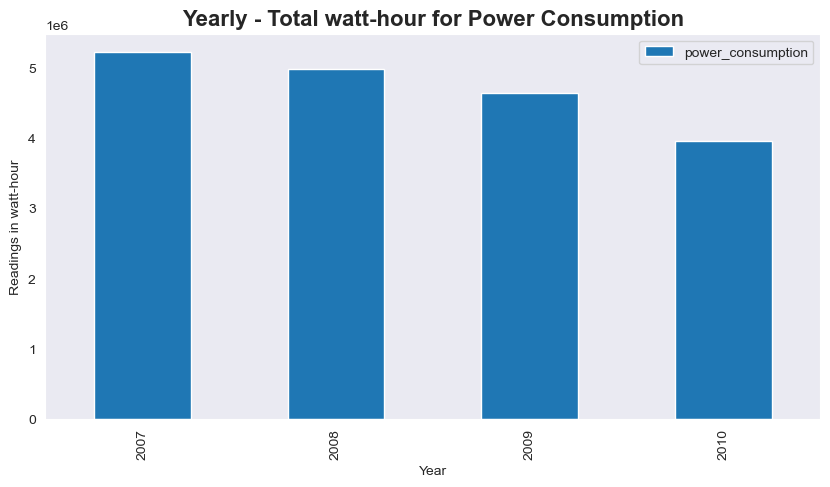

In [171]:
# Yearly - Total watt-hour for Power Consumption

df_power_sub.groupby(df_power_sub.index.year).sum().plot(kind="bar",xlabel='Year',
                    ylabel='Readings in watt-hour', figsize=(10,5))
plt.title('Yearly - Total watt-hour for Power Consumption',fontweight='bold',fontsize=16)
plt.show()

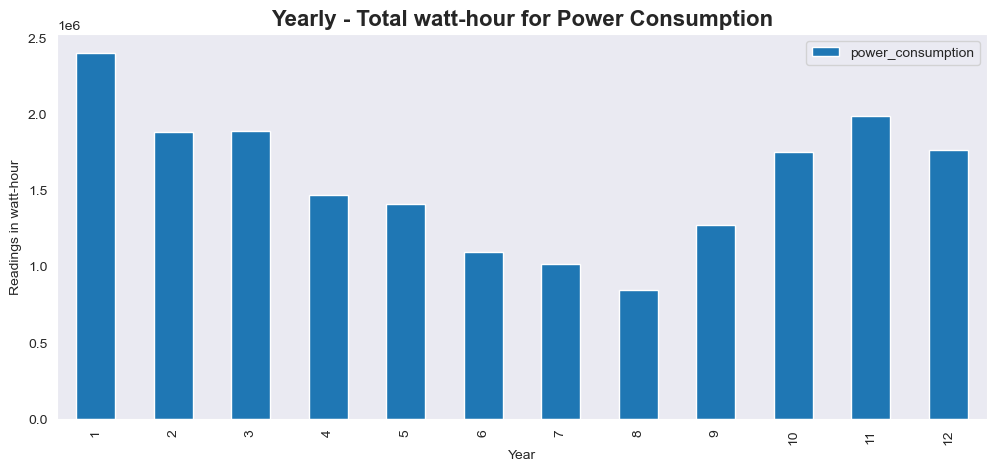

In [172]:
# Monthly - Total watt-hour for Power Consumption

df_power_sub.groupby(df_power_sub.index.month).sum().plot(kind="bar",xlabel='Year',
                    ylabel='Readings in watt-hour',title="Yearly - Total watt-hour for Power Consumption", figsize=(12,5))
plt.title('Yearly - Total watt-hour for Power Consumption',fontweight='bold',fontsize=16)
plt.show()

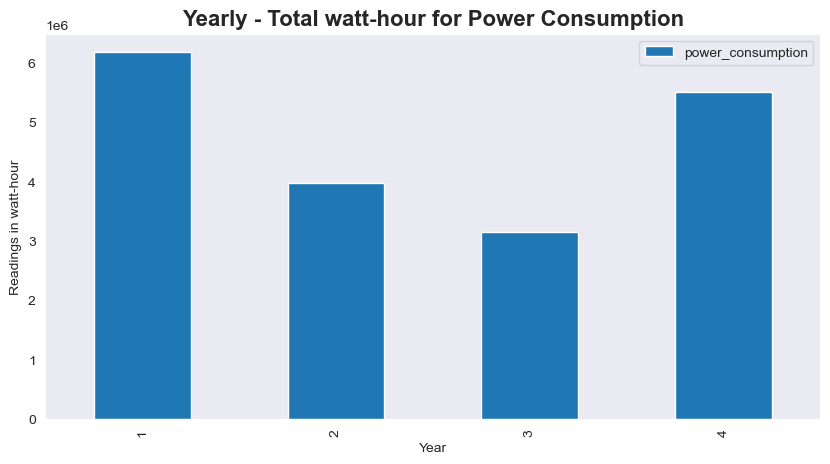

In [173]:
# Quarterly - Total watt-hour for Power Consumption

df_power_sub.groupby(df_power_sub.index.quarter).sum().plot(kind="bar",xlabel='Year',
                    ylabel='Readings in watt-hour', figsize=(10,5))
plt.title('Yearly - Total watt-hour for Power Consumption',fontweight='bold',fontsize=16)
plt.show()

In [148]:
#CREATING DATAFRAME FOR GLOBAL ACTIVE POWER AND GLOBAL REACTIVE POWER

df_active_reactive = df_power_daily[['Global_active_power','Global_reactive_power','Global_intensity']]
df_active_reactive.head()

,Global_active_power,Global_reactive_power,Global_intensity
Dt,,,
2007-01-01,2749.004,148.166,11400.4
2007-01-02,1269.236,190.342,5348.2
2007-01-03,1014.054,196.728,4340.2
2007-01-04,3259.412,202.302,13648.6
2007-01-05,2713.364,173.154,11354.6


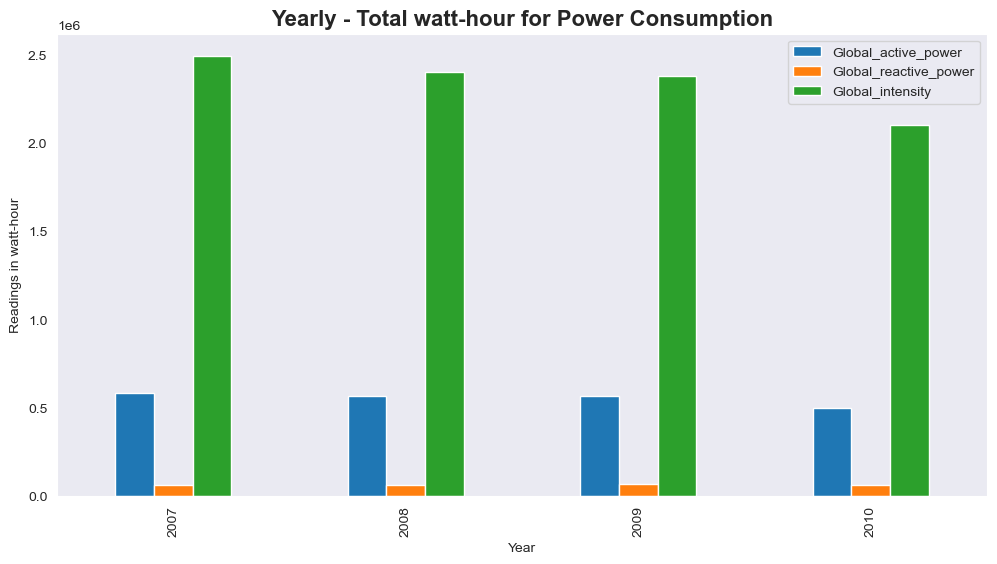

In [174]:
#YEARLY ANALYSIS FOR GLOBAL ACTIVE AND REACTIVE POWER

df_active_reactive.groupby(df_power_daily.index.year).sum().plot(kind="bar",xlabel='Year',ylabel='Readings in watt-hour', figsize=(12,6))
plt.title('Yearly - Total watt-hour for Power Consumption',fontweight='bold',fontsize=16)
plt.show()

In [175]:
#CREATING DATAFRAME FOR Sub_metering_1,Sub_metering_2,Sub_metering_3

df_sub_meterings = df_power_daily[['Sub_metering_1','Sub_metering_2','Sub_metering_3']]
df_sub_meterings.head()

,Sub_metering_1,Sub_metering_2,Sub_metering_3
Dt,,,
2007-01-01,0.0,352.0,5880.0
2007-01-02,0.0,348.0,6562.0
2007-01-03,0.0,344.0,4765.0
2007-01-04,1051.0,7597.0,10896.0
2007-01-05,1483.0,379.0,7602.0


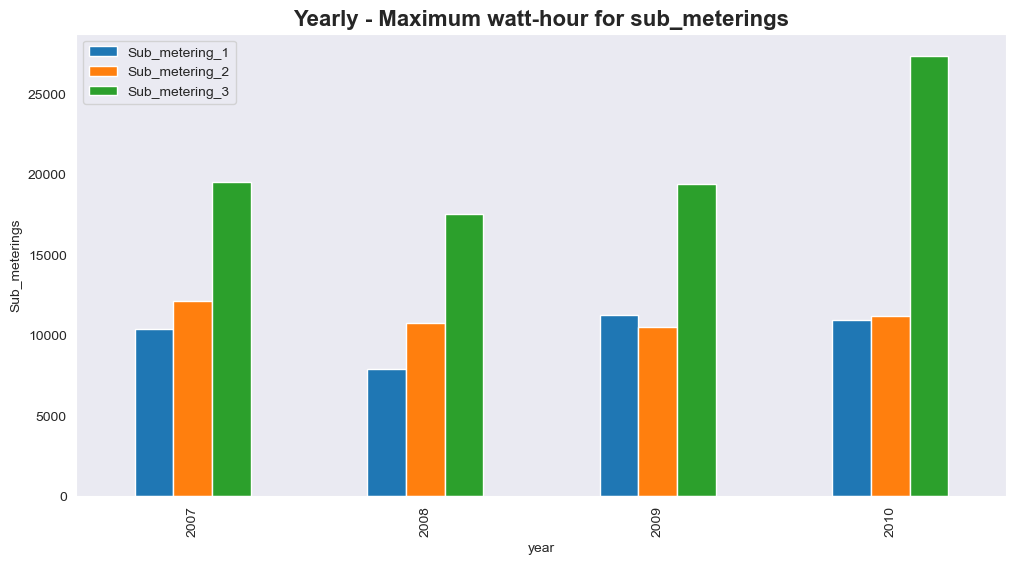

In [176]:
#YEARLY ANALYSIS FOR SUB_METERINGS

df_sub_meterings.groupby(df_sub_meterings.index.year).max().plot(kind='bar',xlabel='year'
        ,ylabel='Sub_meterings',title="Yearly - Maximum watt-hour for sub_meterings",figsize=(12,6))
plt.title('Yearly - Maximum watt-hour for sub_meterings',fontweight='bold',fontsize=16)
plt.show()

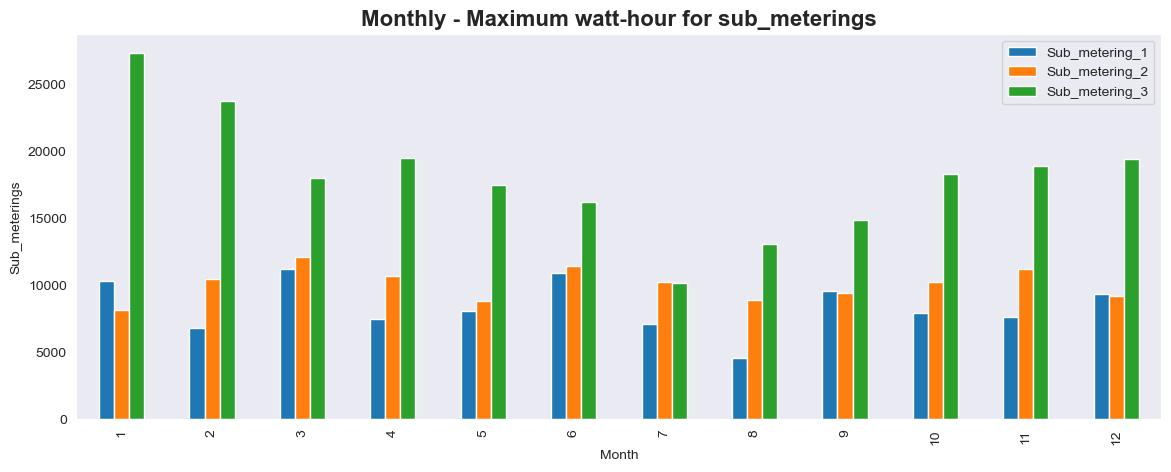

In [177]:
#MONTHLY ANALYSIS

df_sub_meterings.groupby(df_sub_meterings.index.month).max().plot(kind='bar',
        xlabel='Month',ylabel='Sub_meterings',figsize=(14,5))
plt.title('Monthly - Maximum watt-hour for sub_meterings',fontweight='bold',fontsize=16)
plt.show()

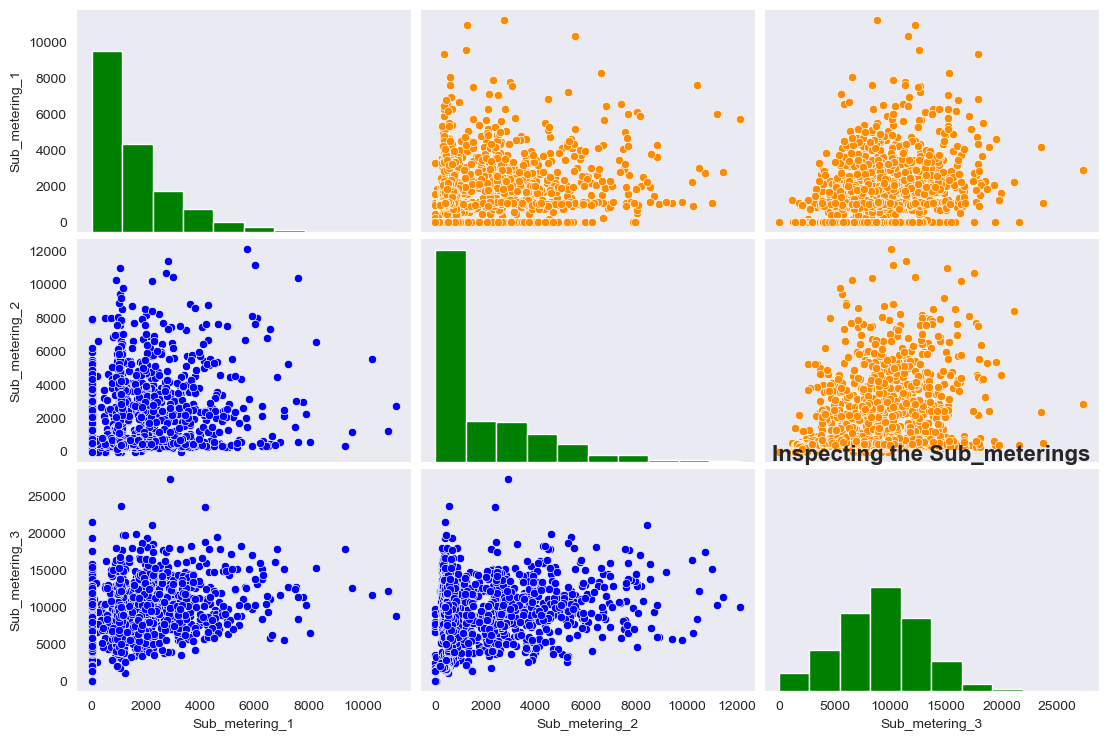

In [178]:
#INSPECTING THE SUB_METERINGS

g=sns.pairplot(df_sub_meterings,aspect=1.5)
g.map_upper(sns.scatterplot,color='darkorange')
g.map_lower(sns.scatterplot, color='blue')
g.map_diag(plt.hist,color='green',bins=10)
plt.title('Inspecting the Sub_meterings', fontsize=16,fontweight='bold')
plt.show()

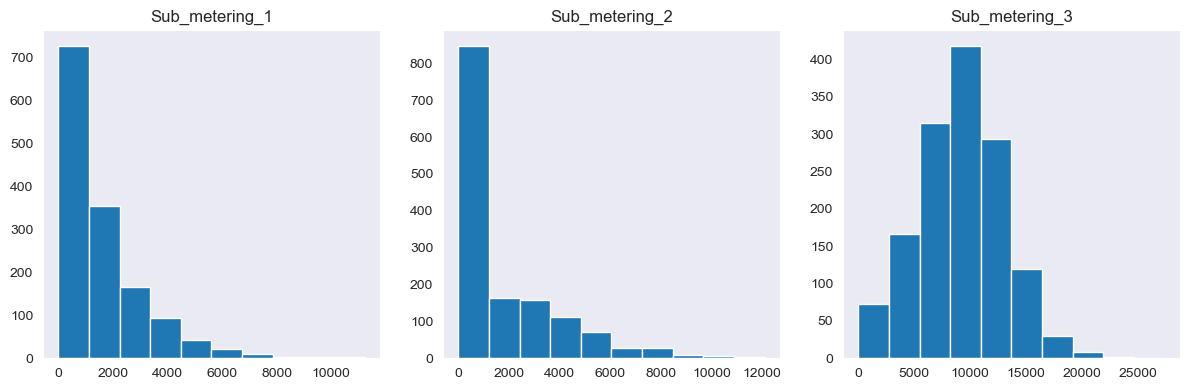

In [179]:
#COMPARING SUB_METERINGS
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

ax[0].hist(df_sub_meterings['Sub_metering_1'])
ax[0].set_title('Sub_metering_1')

ax[1].hist(df_sub_meterings['Sub_metering_2'])
ax[1].set_title('Sub_metering_2')

ax[2].hist(df_sub_meterings['Sub_metering_3'])
ax[2].set_title('Sub_metering_3')

plt.tight_layout()
plt.show()

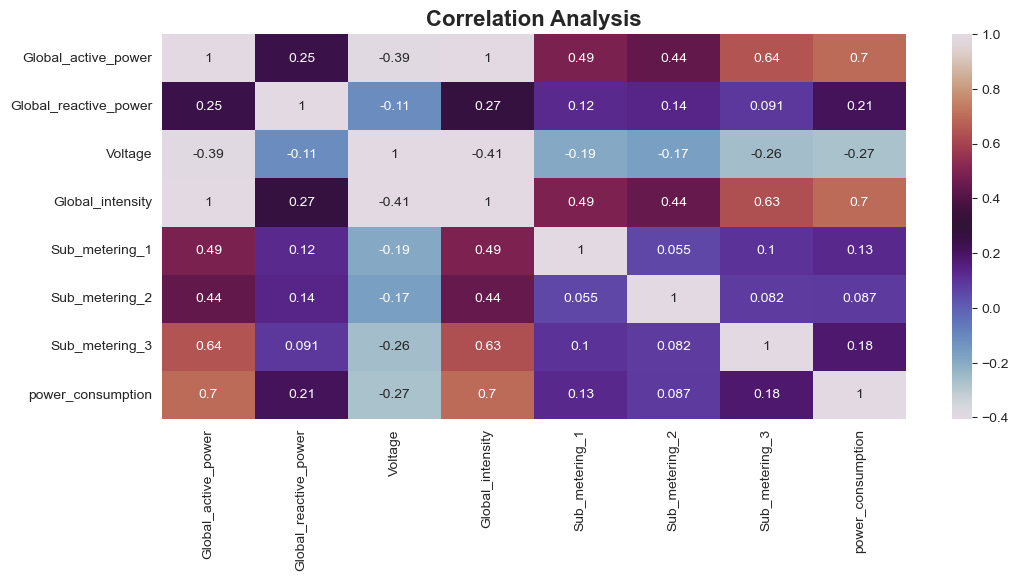

In [180]:
#Correlation Analysis
plt.subplots(figsize=(12,5))
sns.heatmap(df_power_consumption.corr(),annot=True,cmap='twilight')
plt.title('Correlation Analysis', fontsize=16,fontweight='bold')
plt.show()

# XG Boost

### Splitting the data

In [158]:
# Split the data into training and testing sets
df_power=df_power_consumption[['Global_active_power', 'Global_intensity','power_consumption']] 

''' 
Only including these 3 features in the dataframe we would be using for predicting | Forecasting. Power Consumption is the target variable

'''
df_train, df_test = df_power[df_power.index < '2010-01-01'], df_power[df_power.index >= '2010-01-01']

print('Train:\t', len(df_train))
print('Test:\t', len(df_test))

Train:	 1578240
Test:	 475023


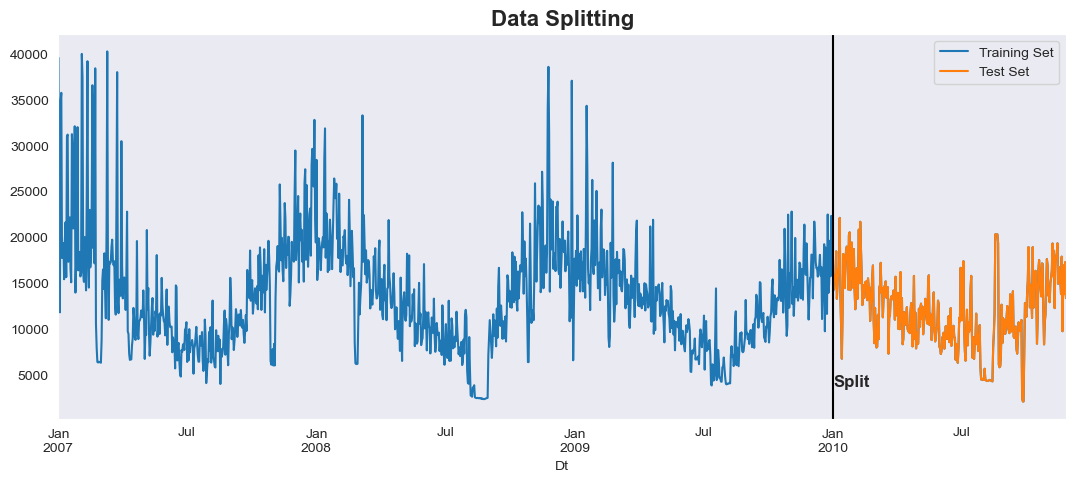

In [181]:
plt.figure(figsize=(13,5))

df_train.index = pd.to_datetime(df_train.index)
df_test.index = pd.to_datetime(df_test.index)

df_train['power_consumption'].resample('D').sum().plot(label='Training Set')
df_test['power_consumption'].resample('D').sum().plot(label='Test Set')
plt.axvline('2010-01-01', color='black', ls='-', lw=1.5)
plt.text('2010-01-01', 3700, 'Split', fontsize=12, fontweight='bold')
plt.title('Data Splitting', fontsize=16,fontweight='bold')
plt.legend()
plt.show()

### Feature Engineering
#### <span style="color:blue"> Create Time Series Features

In [160]:
def date_transform(df_power):
    df = df_power.copy()
    
    df['Hour'] = df.index.hour
    df['Dayofweek'] = df.index.dayofweek
    df['Dayofmonth'] = df.index.day
    df['Dayofyear'] = df.index.dayofyear
    df['Month'] = df.index.month
    df['Quarter'] = df.index.quarter
    df['Year'] = df.index.year
    
    X = df.drop(['power_consumption'], axis=1)
    y = df['power_consumption']
    
    return X, y

In [161]:
X_train, y_train = date_transform(df_train)
X_test, y_test = date_transform(df_test)

### Model Implementation

In [162]:
xgb_model = XGBRegressor(n_estimators=200)
xgb_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)
xgb_pred = xgb_model.predict(X_test)

### Feature Importance

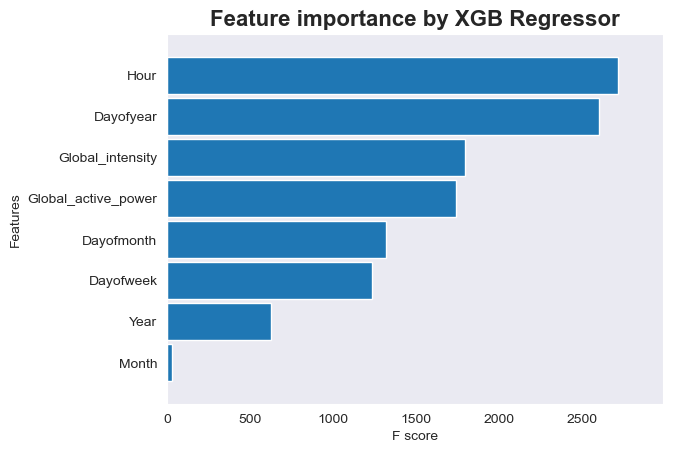

In [182]:
_ = plot_importance(xgb_model, height=0.9,grid=False, show_values=False)
plt.title("Feature importance by XGB Regressor", fontsize=16,fontweight='bold')
plt.show()

### Forecast on Test Set

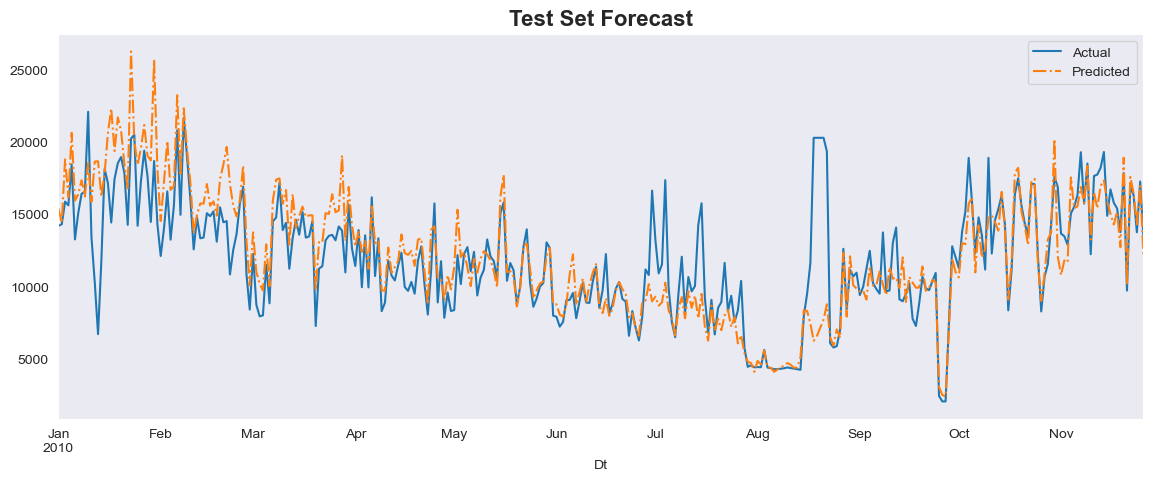

In [183]:
#mae = round(mean_absolute_error(y_test, xgb_pred), 3)

df_plot = pd.DataFrame({'y_test':y_test, 'xgb_pred':xgb_pred})

plt.figure(figsize=(14,5))

df_plot['y_test'].resample('D').sum().plot(label='Actual')
df_plot['xgb_pred'].resample('D').sum().plot(label='Predicted',ls='-.')
plt.title('Test Set Forecast', fontsize=16,fontweight='bold')
plt.legend()
plt.show()

### First Month Predictions

In [165]:
df_test['power_consumption_Prediction'] = xgb_model.predict(X_test)
df_all = pd.concat([df_test, df_train], sort=False)

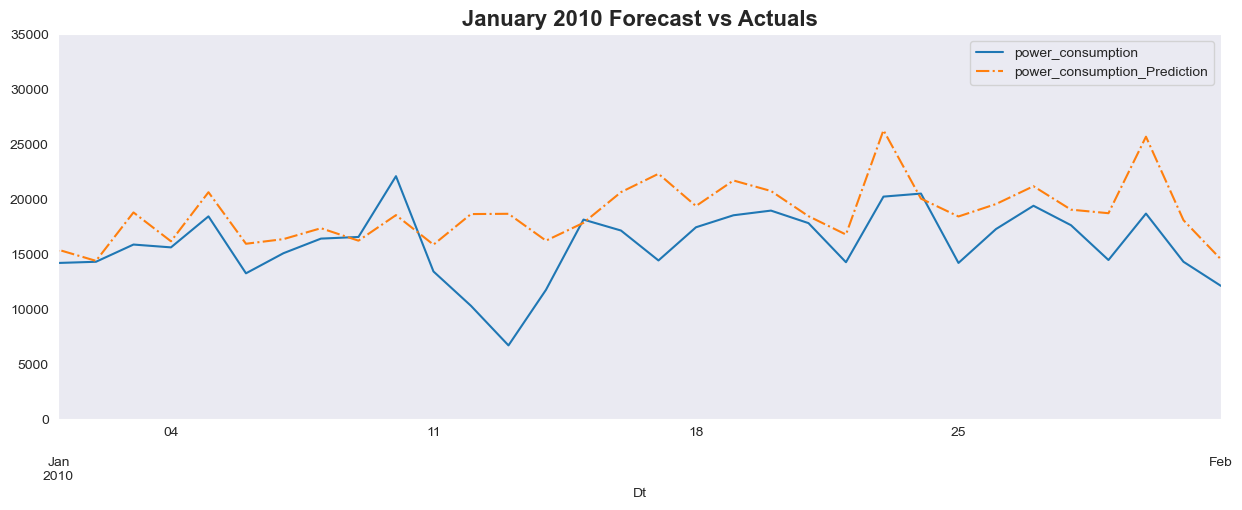

In [184]:
# Plot the forecast with the actuals for January 2010
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = df_all[['power_consumption','power_consumption_Prediction']].resample('D').sum().plot(ax=ax,
                                              style=['-','-.'])
ax.set_xbound(lower='02-01-2010', upper='01-01-2010')
ax.set_ylim(0, 35000)
ax.set_title('January 2010 Forecast vs Actuals', fontsize=16,fontweight='bold')
plt.show()

## Predict the value for next 30 days

### Data Preprocessing - Creating Time series features

In [167]:
#Prepare training data
df_train = df_power_consumption.copy()

df_train['hour'] = df_train.index.hour
df_train['dayofweek'] = df_train.index.dayofweek
df_train['dayofmonth'] = df_train.index.day
df_train['dayofyear'] = df_train.index.dayofyear
df_train['month'] = df_train.index.month
df_train['quarter'] = df_train.index.quarter
df_train['year'] = df_train.index.year

# Features for training
X_train1 = df_train[['hour', 'dayofweek', 'dayofmonth', 'dayofyear', 'month', 'quarter', 'year']]
y_train1 = df_train['power_consumption']

# Step 2: Create future dates
last_date = df_train.index[-1]

# Create 30 days of future dates 
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=720, freq='h')

future_df = pd.DataFrame(index=future_dates)
future_df['hour'] = future_df.index.hour
future_df['dayofweek'] = future_df.index.dayofweek
future_df['dayofmonth'] = future_df.index.day
future_df['dayofyear'] = future_df.index.dayofyear
future_df['month'] = future_df.index.month
future_df['quarter'] = future_df.index.quarter
future_df['year'] = future_df.index.year

In [168]:
# Fitting the model and predicting
xgb_model1 = XGBRegressor(n_estimators=500, learning_rate=0.05)
xgb_model1.fit(X_train1, y_train1)
predictions = xgb_model1.predict(future_df)

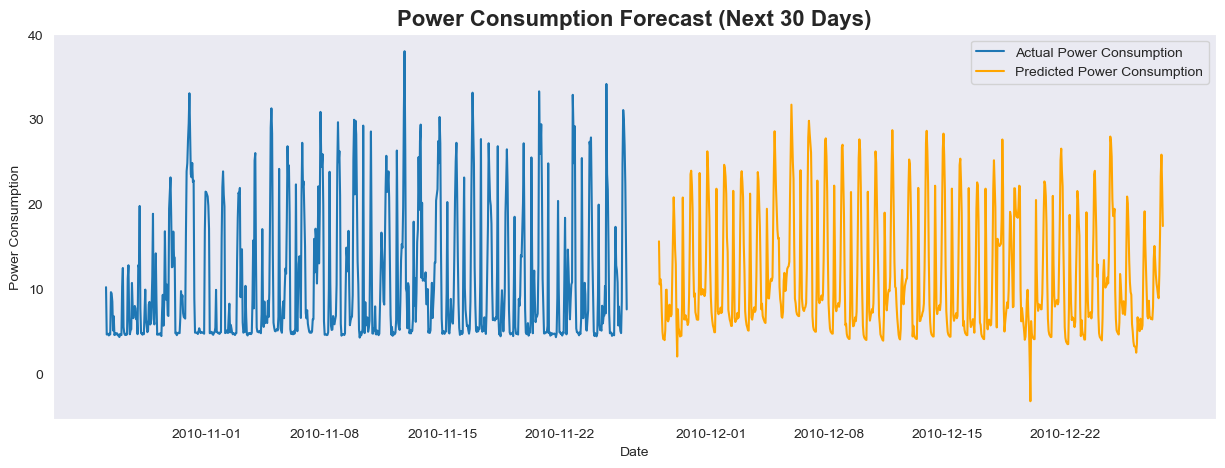

In [186]:
#Plot actual vs predicted values
plt.figure(figsize=(15, 5))

# Plot the most recent 30 days of actual data
df_recent = df_train[(df_train.index < '2010-11-26') & (df_train.index > '2010-10-26')]
df_recent=df_recent.resample('h').mean()
plt.plot(df_recent.index, df_recent['power_consumption'], label='Actual Power Consumption')
plt.plot(future_dates, predictions, label='Predicted Power Consumption', color='orange')
plt.title('Power Consumption Forecast (Next 30 Days)', fontsize=16,fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Power Consumption')
plt.legend()
plt.show()